<a href="https://colab.research.google.com/github/graviraja/100-Days-of-NLP/blob/applications%2Fgeneration/applications/generation/summarization/Email%20Subject%20Generation%20with%20T5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installations

In [1]:
!pip install transformers -q

     |████████████████████████████████| 778kB 6.9MB/s 
     |████████████████████████████████| 3.0MB 12.5MB/s 
     |████████████████████████████████| 890kB 40.6MB/s 
     |████████████████████████████████| 1.1MB 41.8MB/s 


In [2]:
!pip install nlp

     |████████████████████████████████| 1.1MB 6.9MB/s 
     |████████████████████████████████| 63.8MB 47kB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1


### Imports

In [1]:
import time
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

from nlp import load_dataset

from transformers import T5Tokenizer, T5ForConditionalGeneration

import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True

In [4]:
dataset = load_dataset('aeslc')

Using custom data configuration default


In [5]:
dataset.keys()

dict_keys(['train', 'validation', 'test'])

### Data Exploration

In [6]:
train_df = pd.DataFrame(dataset["train"])
valid_df = pd.DataFrame(dataset["validation"])
test_df = pd.DataFrame(dataset["test"])
train_df.head()

,email_body,subject_line
0,"Greg/Phillip, Attached is the Grande Communic...",Service Agreement
1,Phillip & Keith Attached is the first draw re...,Bishops Corner
2,Your Internet Banking accounts are now setup a...,Internet Banking
3,To our IBS Customers that are still hanging in...,Internet Banking
4,Phillip Good Morning!\nI hope you had a wonder...,SMEs for expert stories


In [7]:
len(train_df), len(valid_df), len(test_df)

(14436, 1960, 1906)

In [8]:
print(f"Email: {train_df.iloc[0]['email_body']} \nSubject Line: {train_df.iloc[0]['subject_line']}")

Email: Greg/Phillip,  Attached is the Grande Communications Service Agreement.
The business points can be found in Exhibit C.  I Can get the Non-Disturbance agreement after it has been executed by you and Grande.
I will fill in the Legal description of the property one I have received it.
Please execute and send to:  Grande Communications, 401 Carlson Circle, San Marcos Texas, 78666 Attention Hunter Williams.
<<Bishopscontract.doc>>
 
Subject Line: Service Agreement


In [9]:
train_df.email_body = "summarize: " + train_df.email_body
train_df.head()

,email_body,subject_line
0,"summarize: Greg/Phillip, Attached is the Gran...",Service Agreement
1,summarize: Phillip & Keith Attached is the fi...,Bishops Corner
2,summarize: Your Internet Banking accounts are ...,Internet Banking
3,summarize: To our IBS Customers that are still...,Internet Banking
4,summarize: Phillip Good Morning!\nI hope you h...,SMEs for expert stories


In [10]:
# using only 50% of the data
train_size = 0.5
valid_size = 0.5

train_df = train_df.sample(frac=train_size, random_state=42).reset_index(drop=True)
valid_df = valid_df.sample(frac=valid_size, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=valid_size, random_state=42).reset_index(drop=True)

valid_df.email_body = "summarize: " + valid_df.email_body
test_df.email_body = "summarize: " + test_df.email_body

In [11]:
len(train_df), len(valid_df), len(test_df)

(7218, 980, 953)

In [12]:
emails = train_df.email_body.values
email_lens = [len(email.split()) for email in emails]

subjects = train_df.subject_line.values
subject_lens = [len(subject.split()) for subject in subjects]

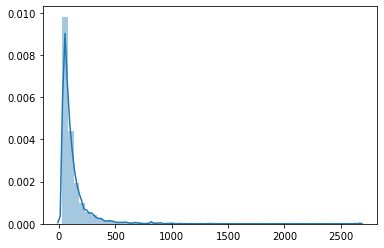

In [13]:
sns.distplot(email_lens)

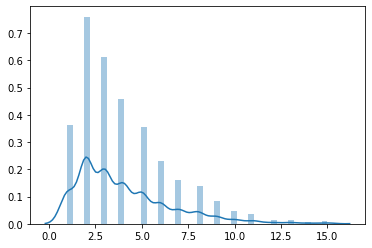

In [14]:
sns.distplot(subject_lens)

### Configurations

In [15]:
MODEL_NAME = "t5-base"
MODEL_PATH = "model.pt"
TOKENIZER = T5Tokenizer.from_pretrained(MODEL_NAME)
MAX_LEN = 200
SUMMARY_LEN = 30
TRAIN_BATCH_SIZE = 2
VALID_BATCH_SIZE = 2
EPOCHS = 2
LR = 1e-4

### Dataset class

In [16]:
class EmailDataset(Dataset):
    def __init__(self, df, tokenizer, source_len, summary_len):
        super().__init__()

        self.tokenizer = tokenizer
        self.data = df
        self.source_len = source_len
        self.summary_len = summary_len
        self.email_body = df.email_body
        self.subject_line = df.subject_line
    
    def __len__(self):
        return len(self.subject_line)
    
    def __getitem__(self, item):
        email = str(self.email_body[item])
        email = " ".join(email.split())

        subject = str(self.subject_line[item])
        subject = " ".join(subject.split())

        source = self.tokenizer.encode_plus(
            email,
            max_length=self.source_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            truncation=True,
            return_tensors='pt')
        
        target = self.tokenizer.encode_plus(
            subject,
            max_length=self.summary_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            truncation=True,
            return_tensors='pt')

        return {
            "source_ids": source["input_ids"].flatten(),
            "source_mask": source["attention_mask"].flatten(),
            "target_ids": target["input_ids"].flatten(),
            "target_mask": target["attention_mask"].flatten()
        }

In [17]:
train_dataset = EmailDataset(train_df, TOKENIZER, MAX_LEN, SUMMARY_LEN)
valid_dataset = EmailDataset(valid_df, TOKENIZER, MAX_LEN, SUMMARY_LEN)
test_dataset = EmailDataset(test_df, TOKENIZER, MAX_LEN, SUMMARY_LEN)

### DataLoaders

In [18]:
train_data_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_data_loader = DataLoader(valid_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False)

In [19]:
# sample check
sample = next(iter(train_data_loader))
sample['source_ids'].shape, sample['source_mask'].shape, sample['target_ids'].shape

(torch.Size([2, 200]), torch.Size([2, 200]), torch.Size([2, 30]))

### Model

In [20]:
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
model.to(device)

Some weights of T5ForConditionalGeneration were not initialized from the model checkpoint at t5-base and are newly initialized: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dr

### Optimizer

In [21]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

### Training Method

In [22]:
def train(data_loader, model, tokenizer, optimizer, device):
    model.train()

    total_steps = len(data_loader)
    epoch_loss = 0

    for idx, batch in enumerate(data_loader):
        optimizer.zero_grad()

        ids = batch["source_ids"].to(device)
        mask = batch["source_mask"].to(device)

        target_ids = batch["target_ids"].to(device)
        
        y_ids = target_ids[:, :-1].contiguous()
        lm_labels = target_ids[:, 1:].clone().detach()
        lm_labels[target_ids[:, 1:] == tokenizer.pad_token_id] = -100

        outputs = model(
            input_ids=ids,
            attention_mask=mask,
            decoder_input_ids=y_ids,
            lm_labels=lm_labels
        )

        loss = outputs[0]
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

        if idx%100 == 0:
            print(f"Step: {idx}/{total_steps} | Loss: {loss.item()}")
    
    return epoch_loss / total_steps

### Validation Method

In [23]:
def evaluate(data_loader, model, tokenizer, device):
    model.eval()

    total_steps = len(data_loader)
    epoch_loss = 0

    with torch.no_grad():
        for idx, batch in enumerate(data_loader):
            ids = batch["source_ids"].to(device)
            mask = batch["source_mask"].to(device)

            target_ids = batch["target_ids"].to(device)
            
            y_ids = target_ids[:, :-1].contiguous()
            lm_labels = target_ids[:, 1:].clone().detach()
            lm_labels[target_ids[:, 1:] == tokenizer.pad_token_id] = -100

            outputs = model(
                input_ids=ids,
                attention_mask=mask,
                decoder_input_ids=y_ids,
                lm_labels=lm_labels
            )

            loss = outputs[0]
            epoch_loss += loss.item()

            if idx%100 == 0:
                print(f"Val Step: {idx}/{total_steps} | Loss: {loss.item()}")
    
    return epoch_loss / total_steps

In [24]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs 

### Training

In [62]:
device

device(type='cuda')

In [25]:
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    start_time = time.time()
    train_loss = train(train_data_loader, model, TOKENIZER, optimizer, device)
    val_loss = evaluate(val_data_loader, model, TOKENIZER, device)
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(model.state_dict(), MODEL_PATH)
    print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
    print(f"\t Train Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):5.4f}")
    print(f"\t Val Loss: {val_loss:.3f} | Val PPL: {np.exp(val_loss):5.4f}")

Step: 0/3609 | Loss: 9.252239227294922
Step: 100/3609 | Loss: 3.096573829650879
Step: 200/3609 | Loss: 2.9988081455230713
Step: 300/3609 | Loss: 3.623548984527588
Step: 400/3609 | Loss: 0.7167368531227112
Step: 500/3609 | Loss: 1.7852838039398193
Step: 600/3609 | Loss: 5.5049333572387695
Step: 700/3609 | Loss: 3.3280117511749268
Step: 800/3609 | Loss: 3.317720413208008
Step: 900/3609 | Loss: 2.0162787437438965
Step: 1000/3609 | Loss: 4.236403465270996
Step: 1100/3609 | Loss: 3.0190610885620117
Step: 1200/3609 | Loss: 4.0998053550720215
Step: 1300/3609 | Loss: 2.6751210689544678
Step: 1400/3609 | Loss: 3.631730079650879
Step: 1500/3609 | Loss: 4.754125595092773
Step: 1600/3609 | Loss: 4.393270015716553
Step: 1700/3609 | Loss: 2.711280345916748
Step: 1800/3609 | Loss: 6.806175231933594
Step: 1900/3609 | Loss: 1.9674499034881592
Step: 2000/3609 | Loss: 4.142590045928955
Step: 2100/3609 | Loss: 4.876557350158691
Step: 2200/3609 | Loss: 0.8874102830886841
Step: 2300/3609 | Loss: 6.202082157

In [26]:
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [27]:
test_loss = evaluate(test_data_loader, model, TOKENIZER, device)
print(f"\t Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):5.4f}")

Val Step: 0/477 | Loss: 1.4821603298187256
Val Step: 100/477 | Loss: 3.4901652336120605
Val Step: 200/477 | Loss: 1.9917783737182617
Val Step: 300/477 | Loss: 2.3270175457000732
Val Step: 400/477 | Loss: 1.977234959602356
	 Test Loss: 2.790 | Test PPL: 16.2773


### Inference

In [108]:
def inference(model, email, tokenizer, device):
    model.eval()

    email = "summarize: " + email

    source = tokenizer.encode_plus(
        email,
        max_length=MAX_LEN,
        pad_to_max_length=True,
        return_attention_mask=True,
        truncation=True,
        return_tensors='pt')
    
    with torch.no_grad():
        ids = source["input_ids"].to(device)
        mask = source["attention_mask"].to(device)

        generated_ids = model.generate(
            input_ids=ids,
            attention_mask=mask,
            max_length=10,
            num_beams=2,
            repetition_penalty=2.5,
            length_penalty=1.0,
            early_stopping=True
        )

        summary = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]

    return summary[0]

In [118]:
email = """
Celeste,  I was under the impression I sent you a message regarding Brad Romine but I cannot find a copy in my msg folder.
There might have been a glitch in the  CC-mail and the message did not go through and wasn't  stored.
I wanted to make the following points:  1.
Brad will not show up on March 15.
He is still working on his dot-com  business and wants to pursue this opportunity.
2.
My recommendation is that we should draw a line in the sand.
Either Brad  or a stipend refund check should show up on March 15.
3.
I told Brad that  a failure to show up on March 15 will not imperil his  future employment opportunities with Enron.
We just need clarity and ability to plan our human resource  needs.
If he decides to re-apply at some point in the future, we shall not hold his  decision  to pursue him  entrepreneurial plans against him.
Please, let me  know what you think.
Vince
"""

In [120]:
email = " ".join(email.split()).strip()
subject = inference(model, email, TOKENIZER, device)
print(subject)

Brad Romine - March 15th


In [116]:
dataset['validation'][800]['email_body']

"Celeste,  I was under the impression I sent you a message regarding Brad Romine but I cannot find a copy in my msg folder.\nThere might have been a glitch in the  CC-mail and the message did not go through and wasn't  stored.\nI wanted to make the following points:  1.\nBrad will not show up on March 15.\nHe is still working on his dot-com  business and wants to pursue this opportunity.\n2.\nMy recommendation is that we should draw a line in the sand.\nEither Brad  or a stipend refund check should show up on March 15.\n3.\nI told Brad that  a failure to show up on March 15 will not imperil his  future employment opportunities with Enron.\nWe just need clarity and ability to plan our human resource  needs.\nIf he decides to re-apply at some point in the future, we shall not hold his  decision  to pursue him  entrepreneurial plans against him.\nPlease, let me  know what you think.\nVince\n"

In [117]:
dataset['validation'][800]['subject_line']

'Brad Romine\n'